# Custom Pytorch data loader

In this notebook, we show case our strategy to separate the data into the Cross-Subject (CS) and Cross-View (CV) benchmarks. To do this, we use lists containing the different names of the samples for each benchmark

We also showcase some code to generate batches from our custom Pytorch data loader.

In [1]:
%matplotlib notebook
import h5py
import numpy as np
import os
import random

from matplotlib import animation

from play_skeleton import *
from src.utils.joints import *

# Global variables (change depending on your setup)
project_dir = os.getcwd() + '/../'
dataset_folder = project_dir + "data/raw/"
skeleton_folder = dataset_folder + "skeletons/"
h5_dataset_path = project_dir + "/data/processed/"

skeleton_dataset_file_name = "skeleton.h5"
log_file_name = "samples_names.txt"

## 1. Create list of samples from the log file (contains all sample names)

In [2]:
# Sample names in a list (total of 56880 samples)
samples_names_list = [line.rstrip('\n') for line in open(h5_dataset_path + log_file_name)]


## 2. Separate between cross-view and cross-subject sets

### 2.1. Create 2 lists with the requirements for each benchmark

In [3]:
# Cross subject
training_subjects = [1, 2, 4, 5, 8, 9, 13, 14, 15, 16, 17, 18, 19, 25, 27, 28, 31, 34, 35, 38]

# Cross view
training_cameras = [2, 3]

### 2.2. Create strings with the training requirements for each benchmark

In [4]:
# Create strings with subject ids : ['P001', 'P002', ..., 'P038']
training_subjects_pxxx = []
for s in training_subjects:
    training_subjects_pxxx.append("P{:03d}".format(s))
    
# Create strings with camera ids : ['C002', 'C003']
training_cameras_cxxx = []
for s in training_cameras:
    training_cameras_cxxx.append("C{:03d}".format(s))
    

### 2.3. Create a list with the cross-subject samples

In [5]:
# Get cs training samples (40320 samples)
cs_training_samples_list = [s for s in samples_names_list if any(xs in s for xs in training_subjects_pxxx)]

# Get cs testing samples (16560 samples)
cs_testing_samples_list = set(samples_names_list) - set(cs_training_samples_list)

# Validation set (5% of training set - 2016 samples) : take random samples out 
cs_validation_samples_list = [cs_training_samples_list.pop(random.randrange(len(cs_training_samples_list))) for _ in range(int(0.05 * len(cs_training_samples_list)))]
# assert not(any(item in cs_training_samples_list for item in cs_testing_samples_list))
# assert not(any(item in cs_training_samples_list for item in cs_validation_samples_list))


### 2.4. Create a list with the cross-view samples

In [6]:
# Get cv training samples (37920 samples)
cv_training_samples_list = [s for s in samples_names_list if any(xs in s for xs in training_cameras_cxxx)]

# Get cv testing samples (18960 samples)
cv_testing_samples_list = set(samples_names_list) - set(cv_training_samples_list)

# Validation set (5% of training set - 1896 samples) : take random samples out 
cv_validation_samples_list = [cv_training_samples_list.pop(random.randrange(len(cv_training_samples_list))) for _ in range(int(0.05 * len(cv_training_samples_list)))]
# assert not(any(item in cv_training_samples_list for item in cv_testing_samples_list))
# assert not(any(item in cv_training_samples_list for item in cv_validation_samples_list))



## 3. PyTorch data loader



### 3.1. Skeleton map example

salute


<IPython.core.display.Javascript object>


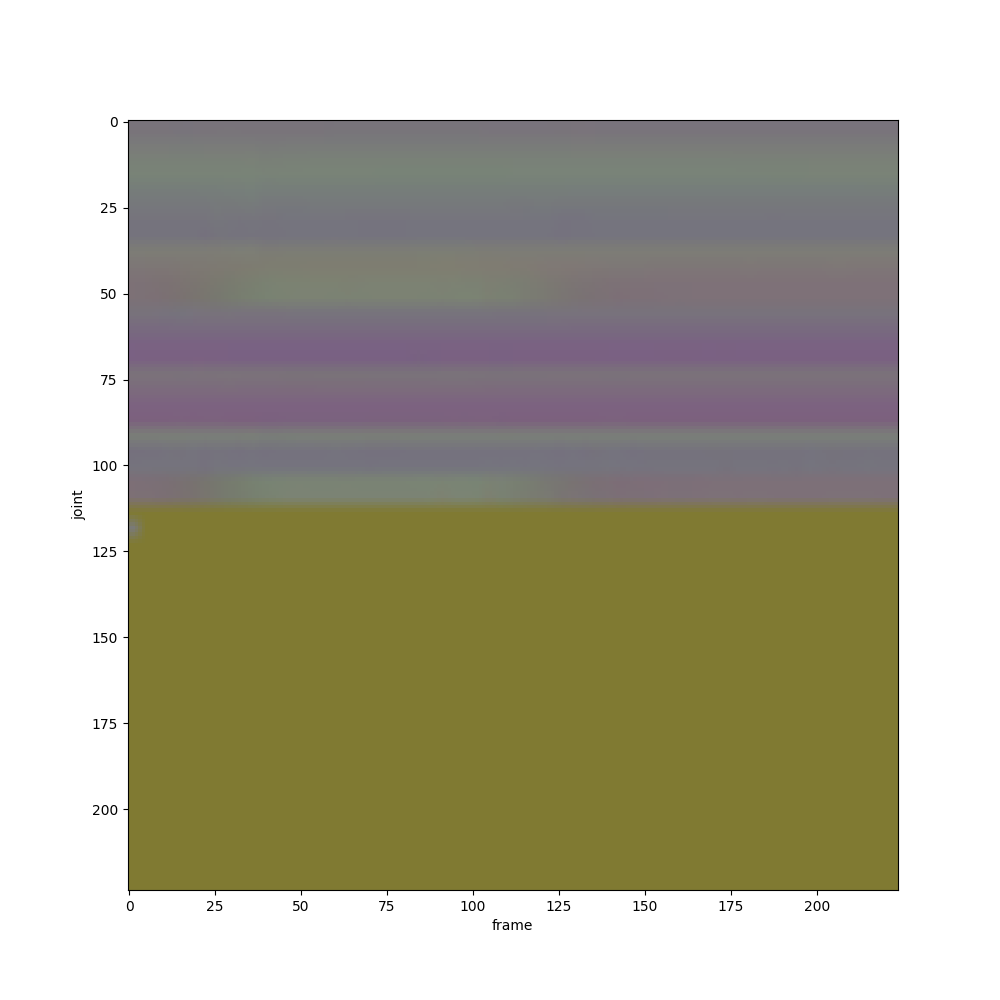

In [7]:
from src.models.h5_pytorch_dataset import *
from src.models.utils import *

dataset = TorchDataset(model_type="FUSION",
                        use_pose=True,
                        use_ir=True,
                        use_cropped_IR=True,
                        data_path=h5_dataset_path,
                        sub_sequence_length=6,
                        augment_data=False,
                        samples_names=samples_names_list)

idx = random.randint(0,len(samples_names_list))
sample, y = dataset[idx]
print(classes[y])
skeleton_map = np.uint8(sample[0])

f = plt.figure()
ax = f.gca()
f.set_size_inches(10,10)

plt.imshow(skeleton_map.transpose(1, 2, 0))
plt.xlabel("frame")
plt.ylabel("joint")
plt.show()

### 3.2. IR sequence example

<IPython.core.display.Javascript object>


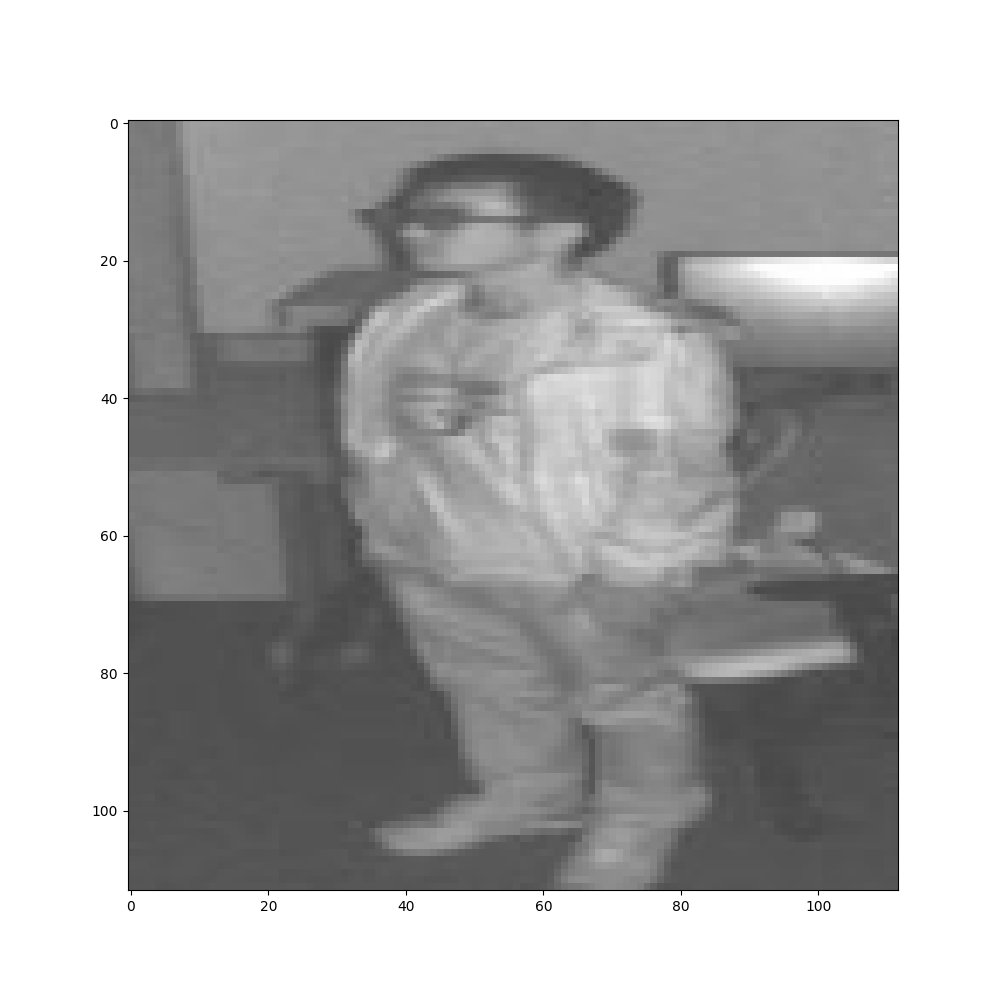

<IPython.core.display.Javascript object>


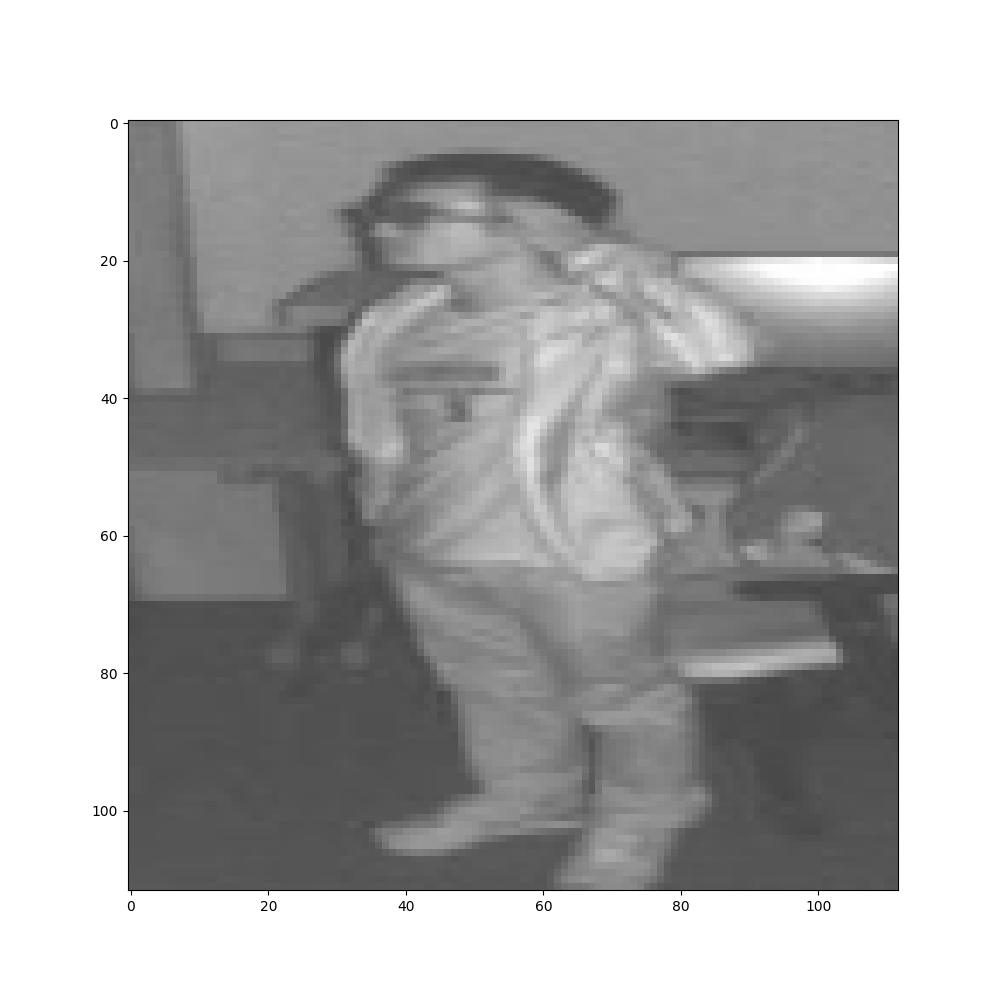

<IPython.core.display.Javascript object>


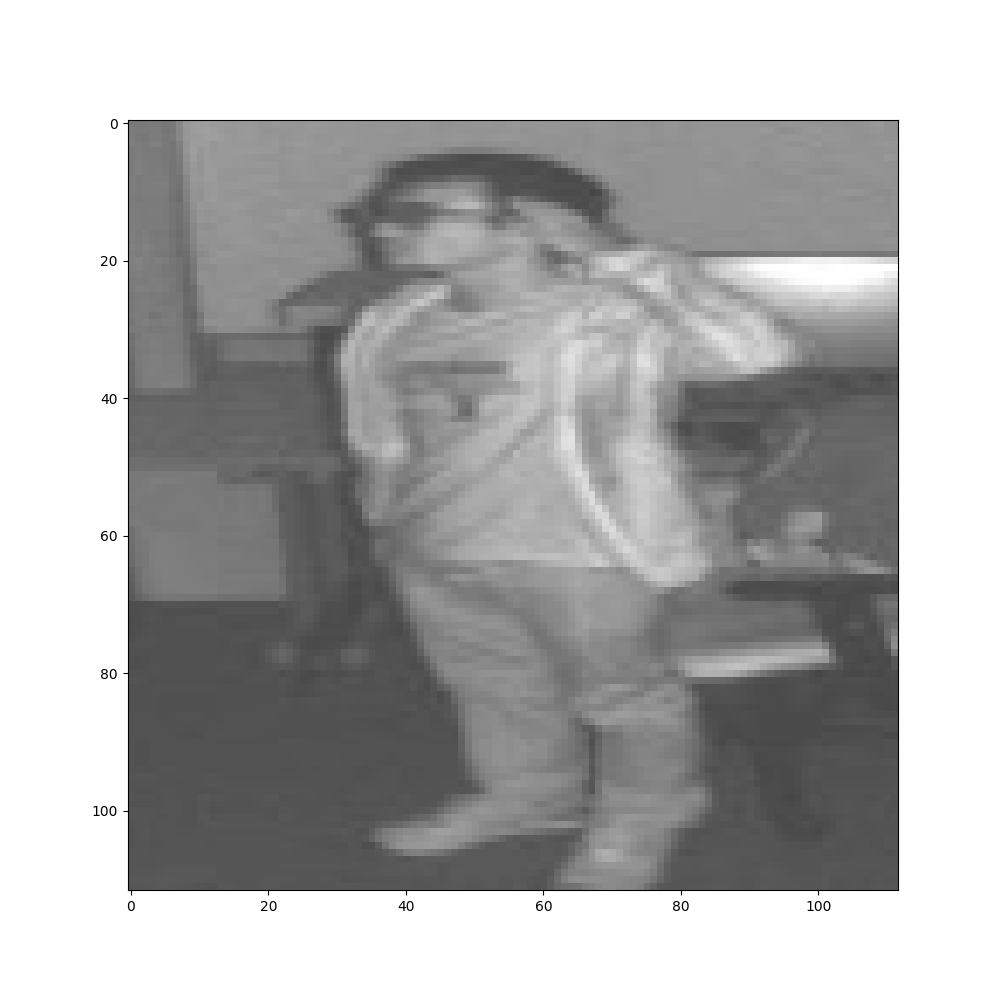

<IPython.core.display.Javascript object>


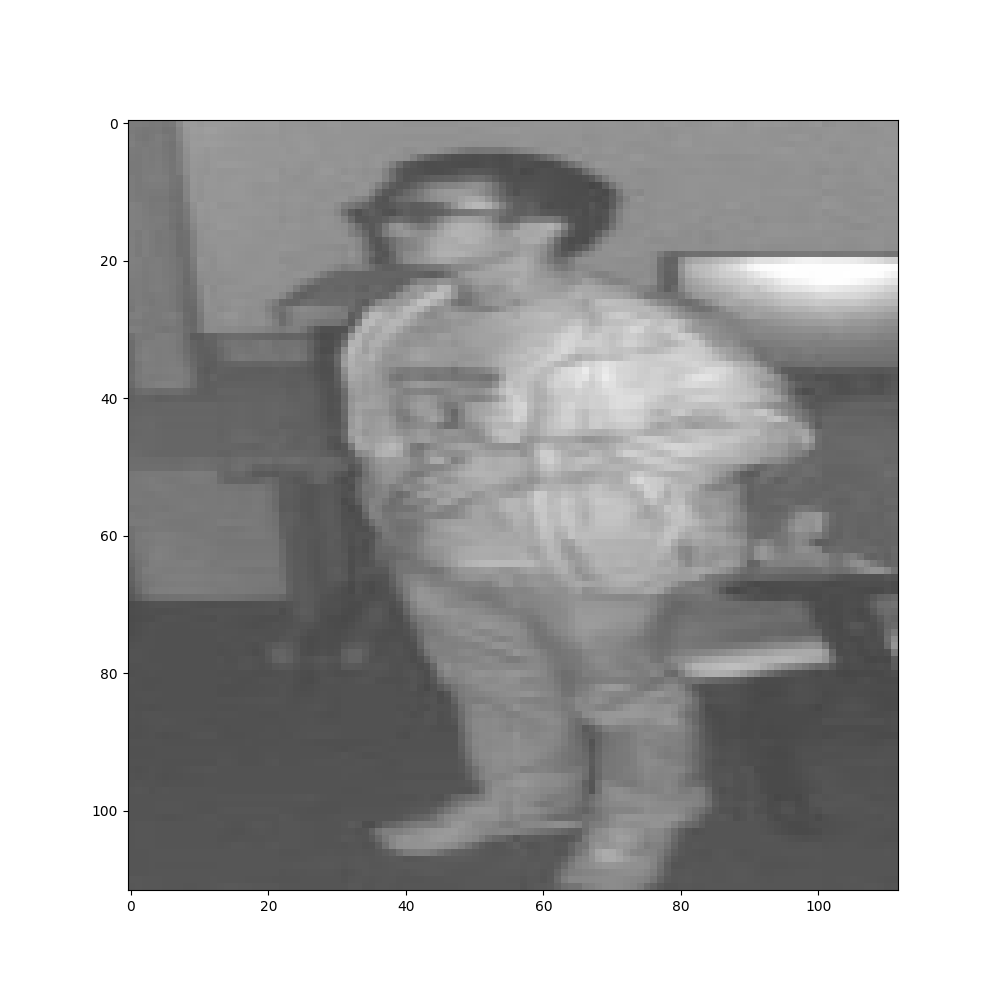

<IPython.core.display.Javascript object>


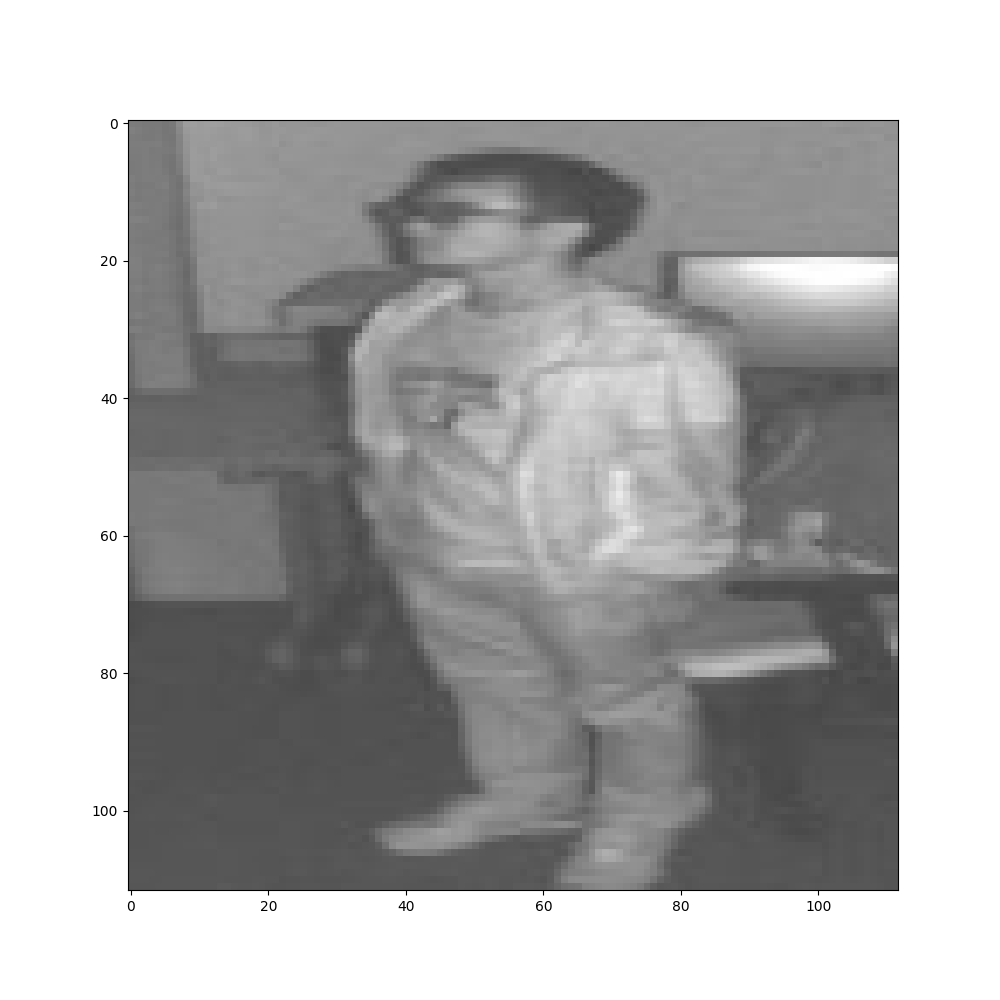

<IPython.core.display.Javascript object>


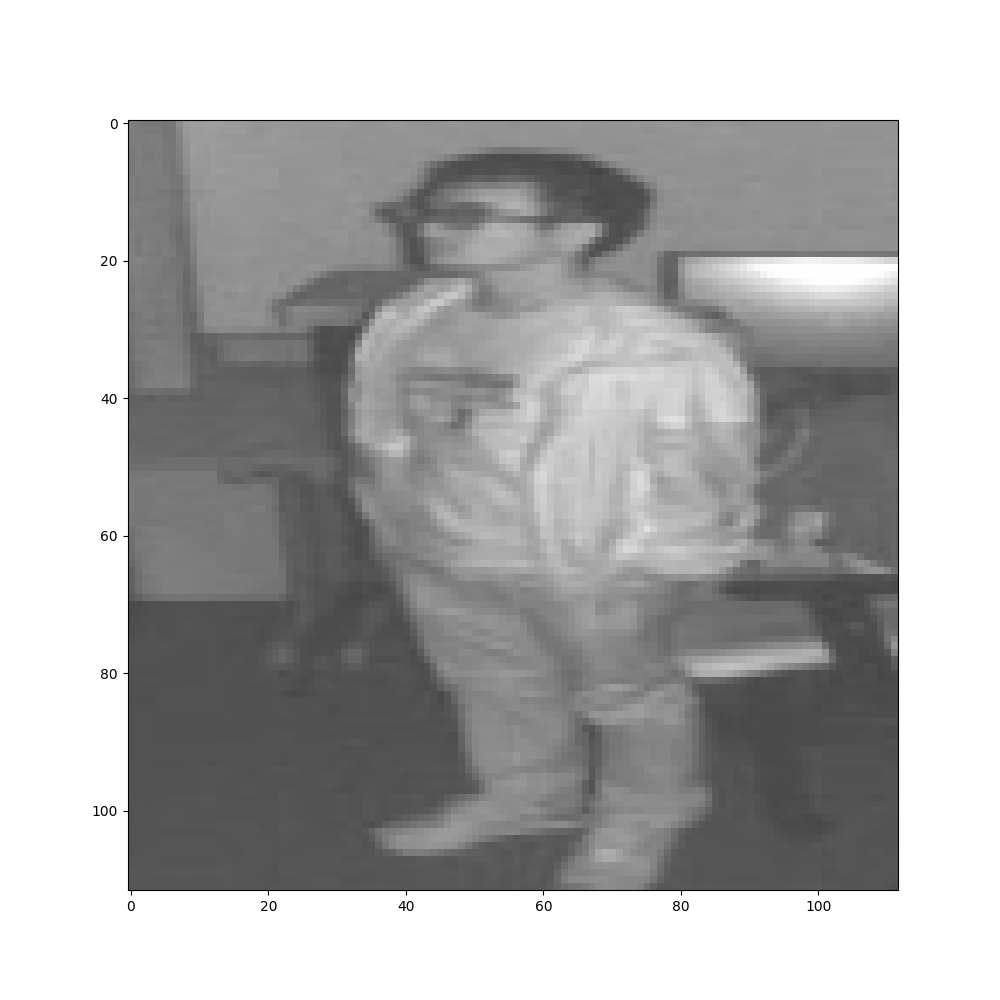

In [8]:
ir_sequence = np.uint8(sample[1])

for t in range(ir_sequence.shape[0]):
    f = plt.figure()
    ax = f.gca()
    f.set_size_inches(10,10)
    plt.imshow(ir_sequence[t].transpose(1, 2, 0))
    plt.show()